Diagnostics in MOM6 can be saved in float or in double precision. This notebook is for testing if it is better to save data in double precision for vorticity budgets or not. 1/4 deg channel model simulation is used for this purpose.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import filter
from dask.diagnostics import ProgressBar
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

In [24]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Test_Precision/"

ds_p1 = xr.open_dataset(ppdir + "ocean_monthly_p1.nc")
ds_p2 = xr.open_dataset(ppdir + "ocean_monthly_p2.nc")

ds_grid = xr.open_dataset(ppdir + "grid.nc")

ds_p1 = xr.merge([ds_p1, ds_grid]) 
ds_p2 = xr.merge([ds_p2, ds_grid])

print(ds_p1, ds_p2)

<xarray.Dataset>
Dimensions:           (Time: 1, nv: 2, time: 2, xh: 320, xq: 320, yh: 272, yq: 272)
Coordinates:
  * xq                (xq) float64 0.25 0.5 0.75 1.0 ... 79.25 79.5 79.75 80.0
  * yh                (yh) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * time              (time) object 0126-01-01 12:00:00 0126-01-02 12:00:00
  * nv                (nv) float64 1.0 2.0
  * xh                (xh) float64 0.125 0.375 0.625 0.875 ... 79.38 79.62 79.88
  * yq                (yq) float64 -69.89 -69.81 -69.72 ... -30.35 -30.13 -29.92
  * Time              (Time) object 0001-01-01 00:00:00
Data variables:
    hf_dudt_2d        (time, yh, xq) float64 ...
    hf_dvdt_2d        (time, yq, xh) float64 ...
    ubt_dt            (time, yh, xq) float64 ...
    vbt_dt            (time, yq, xh) float64 ...
    hf_PFu_2d         (time, yh, xq) float64 ...
    hf_PFv_2d         (time, yq, xh) float64 ...
    hf_CAu_2d         (time, yh, xq) float64 ...
    hf_CAv_2d         (time, y

In [4]:
"""
metrics = {
    ('X',): ['dxCu', 'dxCv'], # X distances
    ('Y',): ['dyCv', 'dyCu'], # Y distances
    ('X', 'Y'): ['areacello', 'areacello_bu', 'areacello_cv', 'areacello_cu'] # Areas
}

grid1 = Grid(ds_p1, metrics=metrics)

depth_u1 = grid.interp(ds_p1['deptho'], 'X',  boundary='fill') 
"""

"\nmetrics = {\n    ('X',): ['dxCu', 'dxCv'], # X distances\n    ('Y',): ['dyCv', 'dyCu'], # Y distances\n    ('X', 'Y'): ['areacello', 'areacello_bu', 'areacello_cv', 'areacello_cu'] # Areas\n}\n\ngrid1 = Grid(ds_p1, metrics=metrics)\n\ndepth_u1 = grid.interp(ds_p1['deptho'], 'X',  boundary='fill') \n"

In [25]:
# Create grid in xgcma and interpolate data on u. v points

rho_0 = 1035.
ds_p1 = ds_p1.isel(time=0)

grid = Grid(ds_p1, coords={'X': {'center': 'xh', 'right': 'xq'},
                           'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

depth_u = grid.interp(ds_p1['deptho'], 'X',  boundary='fill') 
depth_v = grid.interp(ds_p1['deptho'], 'Y',  boundary='fill')
depth_q = grid.interp(depth_v, 'X',  boundary='fill')

beta_u =  grid.diff(ds_p1['Coriolis'], 'Y',  boundary='fill') / ds_p1['dyCu']
beta_v = grid.interp(grid.interp(beta_u, 'X',  boundary='fill'), 'Y',  boundary='fill')

In [26]:
# Compute beta x depth_integrated v

vmo_p1 = beta_v * ds_p1['vmo_2d'] / (rho_0 * ds_p1['dxCv']).load()
vmo_p1 = grid.interp(vmo_p1, 'X',  boundary='fill')

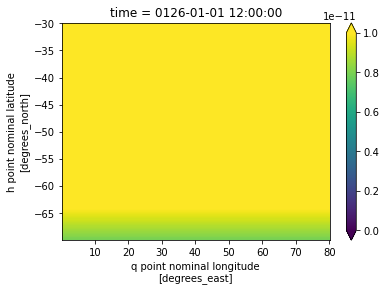

In [45]:
beta_u.plot(vmin=0, vmax=1e-11)

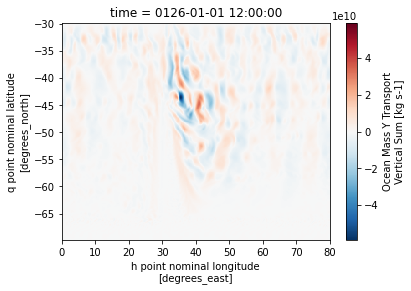

In [46]:
ds_p1['vmo_2d'].plot()

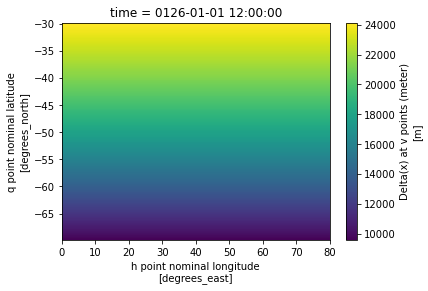

In [47]:
ds_p1['dxCv'].plot()

In [48]:
# Interpolate pbo, eta on u, v points

pbo_u = grid.interp(ds_p1['pbo'] - 1035. * 9.8 * ds_p1['deptho'], 'X',  boundary='fill')
pbo_v = grid.interp(ds_p1['pbo'] - 1035. * 9.8 * ds_p1['deptho'], 'Y',  boundary='fill')

zos_u = grid.interp(ds_p1['zos'], 'X',  boundary='fill')
zos_v = grid.interp(ds_p1['zos'], 'Y',  boundary='fill')

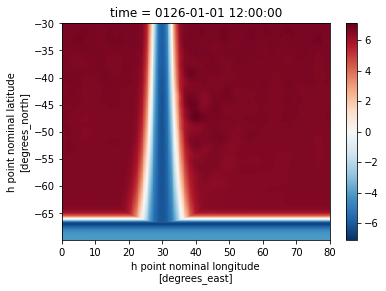

In [9]:
(ds_p1.pbo / (1035. *9.8) - ds_p1.deptho).plot()

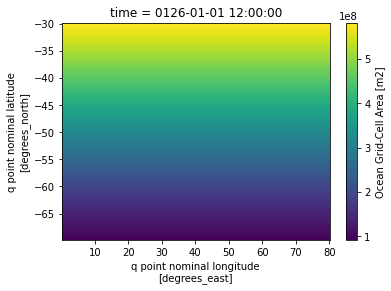

In [10]:
ds_p1['areacello_bu'].plot()

In [49]:
#hx = grid.diff(depth_v * ds_p1['dyCv'], 'X', boundary='fill') / ds_p1['areacello_bu']
#hy = grid.diff(depth_u * ds_p1['dxCu'], 'Y', boundary='fill') / ds_p1['areacello_bu']

hx = grid.diff(depth_u * ds_p1['dyCu'], 'X', boundary='fill') / ds_p1['areacello']
hy = grid.diff(depth_v * ds_p1['dxCv'], 'Y', boundary='fill') / ds_p1['areacello']


pbx = grid.diff(pbo_u * ds_p1['dyCu'], 'X', boundary='fill') / ds_p1['areacello']
pby = grid.diff(pbo_v * ds_p1['dxCv'], 'Y', boundary='fill') / ds_p1['areacello']

zos_x = grid.diff(zos_u * ds_p1['dyCu'], 'X', boundary='fill') / ds_p1['areacello']
zos_y = grid.diff(zos_v * ds_p1['dxCv'], 'Y', boundary='fill') / ds_p1['areacello']

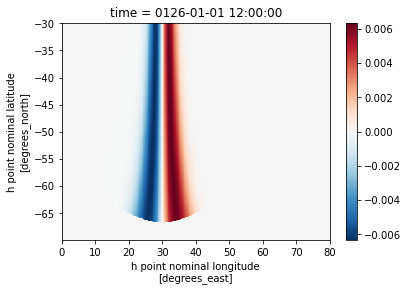

In [30]:
hx.plot(cmap='RdBu_r')

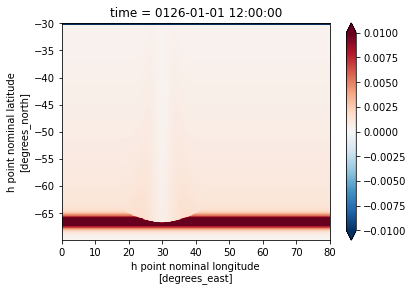

In [32]:
hy.plot(vmin=-0.01, vmax=0.01, cmap='RdBu_r')

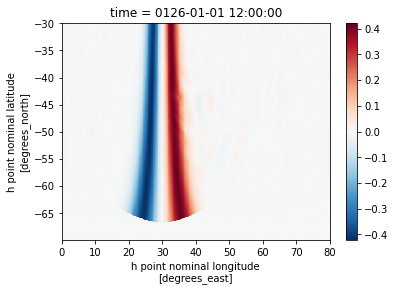

In [50]:
pbx.plot(cmap='RdBu_r')

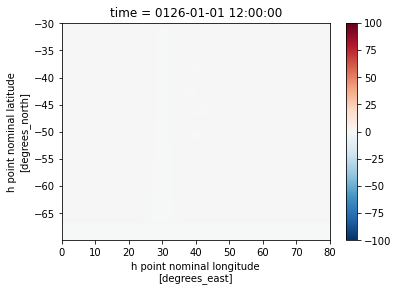

In [51]:
pby.plot(vmin=-100, vmax=100, cmap='RdBu_r')

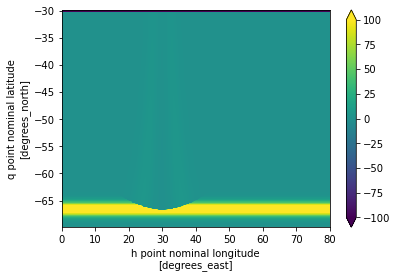

In [13]:
(grid.diff(ds_p1.deptho, 'Y', boundary='fill')).plot(vmin=-100, vmax=100)

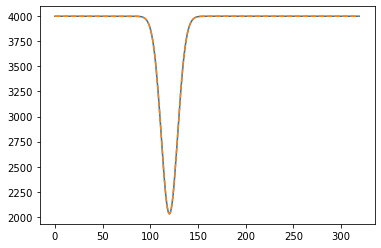

In [22]:
plt.plot(ds_p1.deptho.isel(yh=240))
plt.plot(depth_v.isel(yq=240),'--')

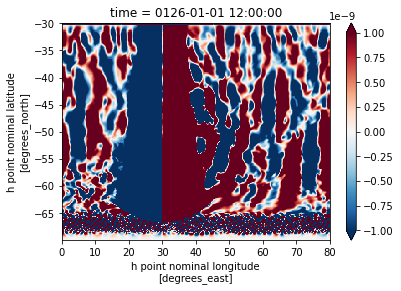

In [55]:
tmp1 = pbx * hy / rho_0
tmp2 = pby * hx / rho_0

BPT = ( pbx * hy - pby * hx ) / rho_0

#BPT_zos = ( zos_x * hy - zos_y * hx ) * 9.81

BPT.plot(vmin=-1e-9, vmax = 1e-9, cmap='RdBu_r')

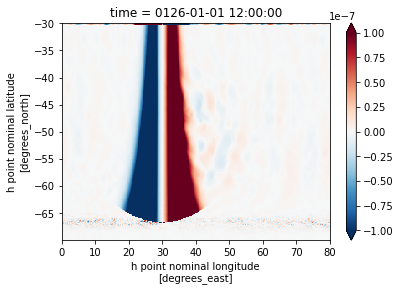

In [53]:
tmp1.plot(vmin=-1e-7, vmax = 1e-7, cmap='RdBu_r')

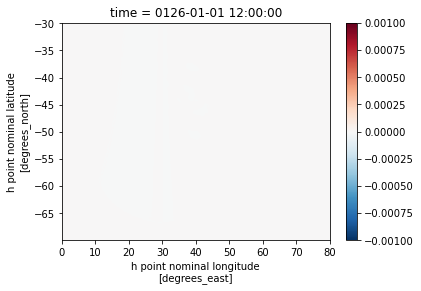

In [54]:
tmp2.plot(vmin=-1e-3, vmax = 1e-3, cmap='RdBu_r')

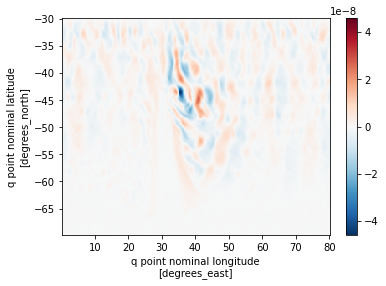

In [53]:
vmo_p1.plot()

In [15]:


pbo_u = grid.interp(ds_p1['pbo'], 'X',  boundary='fill')
pbo_v = grid.interp(ds_p1['pbo'], 'Y',  boundary='fill')

zos_u = grid.interp(ds_p1['zos'], 'X',  boundary='fill')
zos_v = grid.interp(ds_p1['zos'], 'Y',  boundary='fill')

BPT_p1 = (grid.diff(pbo_v * ds_p1['dyCv'], 'X',  boundary='fill') 
       * grid.diff(depth_u * ds_p1['dxCu'], 'Y',  boundary='fill')
      - grid.diff(pbo_u * ds_p1['dxCu'], 'Y',  boundary='fill') 
       * grid.diff(depth_v * ds_p1['dyCv'], 'X',  boundary='fill')) / (ds_p1['areacello_bu'] * ds_p1['areacello_bu'])
BPT_p1 = BPT_p1.load() / (rho_0)

BPT1_p1 = (grid.diff(zos_v * ds_p1['dyCv'], 'X',  boundary='fill') 
       * grid.diff(depth_u * ds_p1['dxCu'], 'Y',  boundary='fill')
      - grid.diff(zos_u * ds_p1['dxCu'], 'Y',  boundary='fill') 
       * grid.diff(depth_v * ds_p1['dyCv'], 'X',  boundary='fill')) / (ds_p1['areacello_bu'] * ds_p1['areacello_bu'])
BPT1_p1 = rho_0 * 9.81 * BPT1_p1.load() / (rho_0)

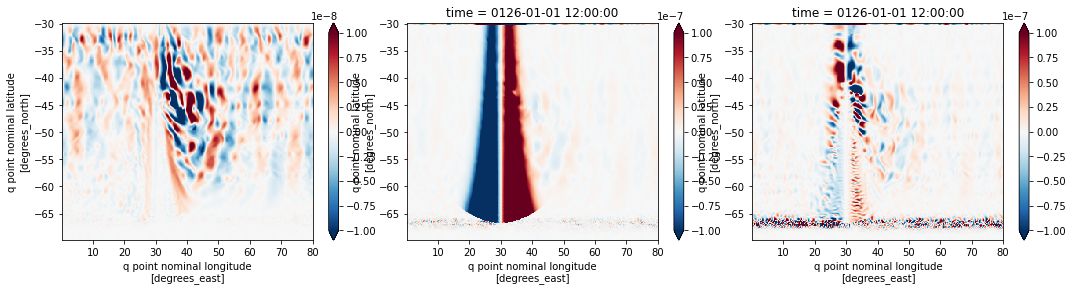

In [16]:
grid1 = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid1[0, 0])
vmo_p1.plot(vmin=-1.e-8, vmax=1.e-8, cmap='RdBu_r')

ax = fig.add_subplot(grid1[0, 1])
BPT_p1.plot(vmin=-1.e-7, vmax=1.e-7, cmap='RdBu_r')

ax = fig.add_subplot(grid1[0, 2])
BPT1_p1.plot(vmin=-1.e-7, vmax=1.e-7, cmap='RdBu_r')

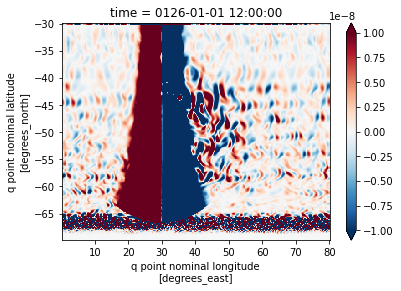

In [17]:
(BPT1_p1 - BPT_p1).plot(vmin=-1.e-8, vmax=1.e-8, cmap='RdBu_r')

In [18]:
rho_0 = 1035.
ds_p2 = ds_p2.isel(time=0)

grid = Grid(ds_p2, coords={'X': {'center': 'xh', 'right': 'xq'},
                           'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

depth_u = grid.interp(ds_p2['deptho'], 'X',  boundary='fill') 
depth_v = grid.interp(ds_p2['deptho'], 'Y',  boundary='fill')
depth_q = grid.interp(depth_v, 'X',  boundary='fill')

beta_u =  grid.diff(ds_p2['Coriolis'], 'Y',  boundary='fill') / ds_p2['dyCu']
beta_v = grid.interp(grid.interp(beta_u, 'X',  boundary='fill'), 'Y',  boundary='fill')

In [19]:
vmo_p2 = beta_v * ds_p2['vmo_2d'] / (rho_0 * ds_p2['dxCv']).load()
vmo_p2 = grid.interp(vmo_p2, 'X',  boundary='fill')

pbo_u = grid.interp(ds_p2['pbo'], 'X',  boundary='fill')
pbo_v = grid.interp(ds_p2['pbo'], 'Y',  boundary='fill')

zos_u = grid.interp(ds_p2['zos'], 'X',  boundary='fill')
zos_v = grid.interp(ds_p2['zos'], 'Y',  boundary='fill')

BPT_p2 = (grid.diff((pbo_v)*ds_p2['dyCv'], 'X',  boundary='fill') 
       * grid.diff((depth_u + zos_u)* ds_p2['dxCu'], 'Y',  boundary='fill')
      - grid.diff((pbo_u)* ds_p2['dxCu'], 'Y',  boundary='fill') 
       * grid.diff((depth_v + zos_v)* ds_p2['dyCv'], 'X',  boundary='fill')) / (ds_p2['areacello_bu'] * ds_p2['areacello_bu'])
BPT_p2 = BPT_p2.load() / (rho_0)

BPT1_p2 = (grid.diff(zos_v * ds_p2['dyCv'], 'X',  boundary='fill') 
       * grid.diff(depth_u * ds_p2['dxCu'], 'Y',  boundary='fill')
      - grid.diff(zos_u * ds_p2['dxCu'], 'Y',  boundary='fill') 
       * grid.diff(depth_v * ds_p2['dyCv'], 'X',  boundary='fill')) / (ds_p2['areacello_bu'] * ds_p2['areacello_bu'])
BPT1_p2 = rho_0 * 9.81 * BPT1_p2.load() / (rho_0)

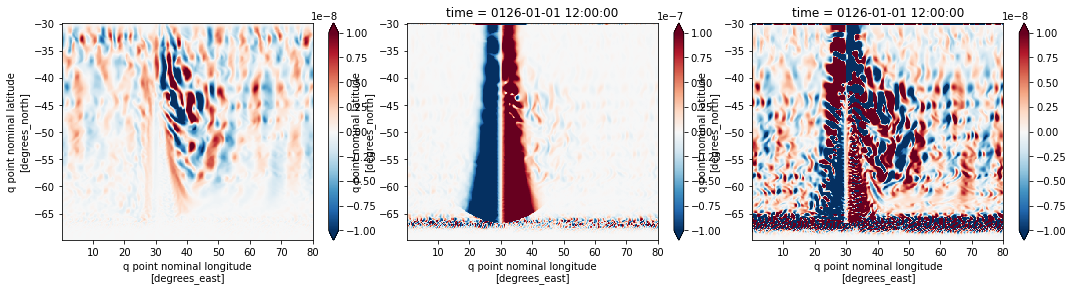

In [20]:
grid1 = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid1[0, 0])
vmo_p2.plot(vmin=-1.e-8, vmax=1.e-8, cmap='RdBu_r')

ax = fig.add_subplot(grid1[0, 1])
BPT_p2.plot(vmin=-1.e-7, vmax=1.e-7, cmap='RdBu_r')

ax = fig.add_subplot(grid1[0, 2])
BPT1_p2.plot(vmin=-1.e-8, vmax=1.e-8, cmap='RdBu_r')

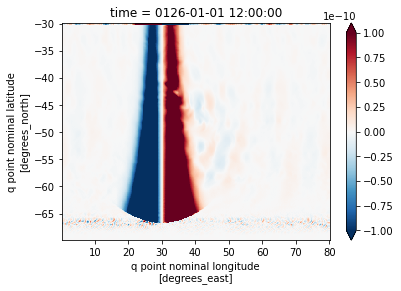

In [24]:
BPT1_p2.plot(vmin=-1.e-10, vmax=1.e-10, cmap='RdBu_r')